# NBA Game Prediction: Logistic Regression (Modelling Teams)
Written by Nicholas Cannon 22241579

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay, precision_recall_curve,
    PrecisionRecallDisplay
)

%matplotlib inline

DATA_DIR = os.path.join('..', 'data', 'processed', 'teams')
STATE = 42
team_ids = os.listdir(DATA_DIR)
NON_FEATURE_COLS = ['GAME_ID', 'DATE', 'SEASON', 'TEAM', 'OPPONENT']

In [88]:
def run_metrics(y_pred, y_true, y_score=None, cf_only=False):
    """Display Standard graphs and metrics for model evaluation"""
    print('F1 =', f1_score(y_true, y_pred, average='weighted'))
    print('n games =', len(y_pred))
    
    # create subplots and adjust axes settings
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    ax2.set_xlim((0, 1))
    ax2.set_ylim((0, 1.01))
    ax3.set_xlim((0, 1))
    ax3.set_ylim((0, 1.01))
    ax2.set_aspect('equal', 'box')
    ax3.set_aspect('equal', 'box')
    
    # CF Matrix
    ConfusionMatrixDisplay(
        confusion_matrix(y_true, y_pred),
        display_labels=['Home Lose', 'Home Win']
    ).plot(cmap=plt.cm.Blues, ax=ax1)
    
    if not cf_only:
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr)).plot(ax=ax2)

        # PR Curve
        prec, recall, _ = precision_recall_curve(y_true, y_score)
        PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax3)
    
    plt.show()


def preprocess_team(team_id, drop_adv=False, season_avg=False, window=5, drop_percentages=False, 
                    split_data=True, test_size=0.2):
    """Preprocess the given teams data set with configurable options"""
    df = pd.read_csv(os.path.join(DATA_DIR, team_id))

    # shift label up 1 game
    df['WON'] = df['WON'].shift(periods=-1)
    df.dropna(inplace=True)

    # get a copy of the columns not run through averaging
    non_avgs = df[[*NON_FEATURE_COLS, 'HOME']].copy()

    # separate features and labels (and drop non feature cols)
    X = df.drop([*NON_FEATURE_COLS, 'WON', 'HOME'], axis=1)
    y = df['WON']
    
    # drop derived cols
    if drop_percentages:
        X = X.drop(['FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'RBC'], axis=1)
    else:
        X = X.drop(['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'ORBC', 'DRBC',], axis=1)

    # drop the advanced stats
    if drop_adv:
        X = X.drop(['PLUS_MIN', 'TM_TOV_PCT', 'OFF_RATING', 'DEF_RATING', 
                    'TS_PCT', 'PACE', 'PTS_OFF_TO', 'PTS_2ND_CHANCE',
                    'PTS_FB', 'PTS_PAINT', 'DIST', 'ORBC', 'DRBC', 'RBC', 'TCHS',
                    'PASS', 'CFGM', 'CFGA', 'UFGM', 'UFGA'], axis=1, errors='ignore')

    # Run averaging and add the non_avg cols after
    if season_avg:
        X = X.expanding().mean()
        X = pd.concat([non_avgs, X], axis=1)
    else:
        X = X.rolling(window).mean()
        X = pd.concat([non_avgs, X], axis=1)

        X.dropna(inplace=True) # drop first few games
        y = y[window-1:]
    
    if split_data:
        return train_test_split(X, y, test_size=test_size, random_state=STATE)
    else:
        return X, y
    
    
def build_dataset(**preprocess_args):
    """Build features and labels from team data sets"""
    X_full, y_full, test_full = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    for team_id in team_ids:
        X_team, y_team = preprocess_team(team_id, split_data=False, **preprocess_args)
        
        # grab teams last season for testing
        test_full = pd.concat([test_full, X_team.iloc[-82:, :]], ignore_index=True)
        
        X_full = pd.concat([X_full, X_team.iloc[:-82, :]], ignore_index=True)
        y_full = pd.concat([y_full, y_team.iloc[:-82]], ignore_index=True)
    
    # convert y to column vector
    y_full = y_full.iloc[:, 0]
    
    # drop the non feature cols
    X_full.drop(NON_FEATURE_COLS, inplace=True, axis=1)

    # train / test split
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=STATE)
    
    return X_train, X_test, y_train, y_test, test_full
    

def test_model(clf, features):
    """Test given model using provided features on 2018 season."""
    y_pred, y_true = [], []
    h_probs, a_probs = [], []
    game_order = {}
    
    # Read and process the labels from the individual teams data,
    # the labels used in the training data are shifted up by 1 game.
    # This gives access to the ground truth for each game in the 2018 season.
    labels = pd.DataFrame()
    for team_id in team_ids:
        df = pd.read_csv(os.path.join(DATA_DIR, team_id))
        
        # filter by 2018 season
        df = df[df['SEASON'] == 2018]
        
        # create list of game_ids so we can fetch the previous game features
        game_order[team_id[:-4]] = df['GAME_ID'].tolist()
        
        # convert back to home / away perspectives
        df['H_ID'] = df.apply(lambda r: r['TEAM'] if r['HOME'] == 1 else r['OPPONENT'], axis=1)
        df['A_ID'] = df.apply(lambda r: r['TEAM'] if r['HOME'] == 0 else r['OPPONENT'], axis=1)
        df['HOME_WIN'] = df.apply(lambda r: 1 - (r['WON'] ^ r['HOME']), axis=1)
        
        df = df[['GAME_ID', 'DATE', 'H_ID', 'A_ID', 'HOME_WIN']]
        
        labels = pd.concat([labels, df], ignore_index=True)

    # each game will have two entries, one for each team so drop the dups
    labels.drop_duplicates(inplace=True)
    
    # drop any games that aren't in the feature set
    labels = labels[labels['GAME_ID'].isin(features['GAME_ID'].unique())]
    
    # make predictions on all feature games
    for _, game in labels.iterrows():
        # find the index of this game
        h_game_idx = game_order[str(game['H_ID'])].index(game['GAME_ID'])
        a_game_idx = game_order[str(game['A_ID'])].index(game['GAME_ID'])
        
        # pull out home / away team features for their previous game
        h_data = features[
            (features['TEAM'] == game['H_ID']) & 
            (features['GAME_ID'] == game_order[str(game['H_ID'])][h_game_idx - 1])
        ]
        a_data = features[
            (features['TEAM'] == game['A_ID']) & 
            (features['GAME_ID'] == game_order[str(game['A_ID'])][a_game_idx - 1])
        ]
        
        # skip games that don't have features for both home and away
        if h_data.empty or a_data.empty:
            continue

        # clean features
        h_data = h_data.iloc[0].drop(NON_FEATURE_COLS).values
        a_data = a_data.iloc[0].drop(NON_FEATURE_COLS).values

        # get the probability of winning next game
        prob_h_win = clf.predict_proba([h_data])[0][1]
        prob_a_win = clf.predict_proba([a_data])[0][1]
        
        # record prediction results, scores and label
        y_pred.append(1 if prob_h_win >= prob_a_win else 0)
        y_true.append(game['HOME_WIN'])
        h_probs.append(prob_h_win)
        a_probs.append(prob_a_win)

    return y_pred, y_true, a_probs, h_probs

# Logistic Regression

In [76]:
def train_lr(**preprocess_args):
    """Train Logistic Regression model with grid search cv"""
    # build dataset with given processing args
    X_train, X_test, y_train, y_test, test_full = build_dataset(**preprocess_args)
    
    # StdScaler speeds up training quite a bit
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=STATE))
    ])
    params = {
        'clf__C': [1.0, 0.8, 0.5],
        'clf__penalty': ['l1', 'l2']
    }

    clf = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=5)
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)

    # local model results summary
    print('**Local Model Results**')
    print('-'*30)
    print('F1 = ', f1_score(y_test, y_pred))
    # print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('Best Parameters = ', clf.best_params_)
    print('-'*30)

    return clf.best_estimator_, test_full

## Experiment 1: 5 Game Moving Average

In [83]:
clf_1, test_features_1 = train_lr(season_avg=False, window=5)

**Local Model Results**
------------------------------
F1 =  0.5889070146818923
Best Parameters =  {'clf__C': 0.5, 'clf__penalty': 'l1'}
------------------------------


F1 = 0.6270926846189091
n games = 1202


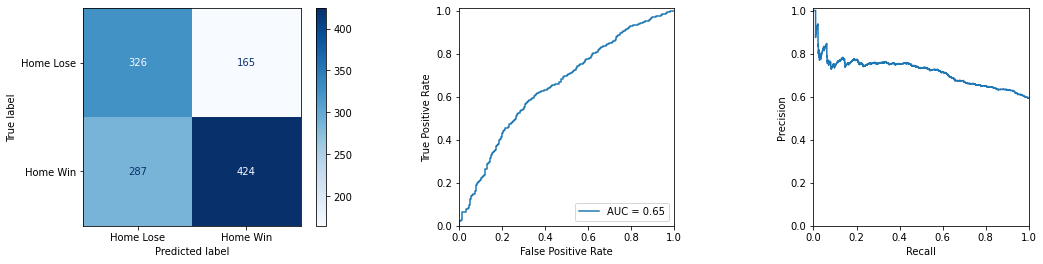

In [86]:
y_pred_1, y_true_1, *y_scores_1 = test_model(clf_1, test_features_1)
run_metrics(y_pred_1, y_true_1, y_score=y_scores_1[1])

In [87]:
accuracy_score(y_pred_1, y_true_1)

0.6239600665557404

## Experiment 2: Season Average

In [89]:
clf_2, test_features_2 = train_lr(season_avg=True)

**Local Model Results**
------------------------------
F1 =  0.593633732947499
Best Parameters =  {'clf__C': 1.0, 'clf__penalty': 'l2'}
------------------------------


F1 = 0.5982627726398478
n games = 1202


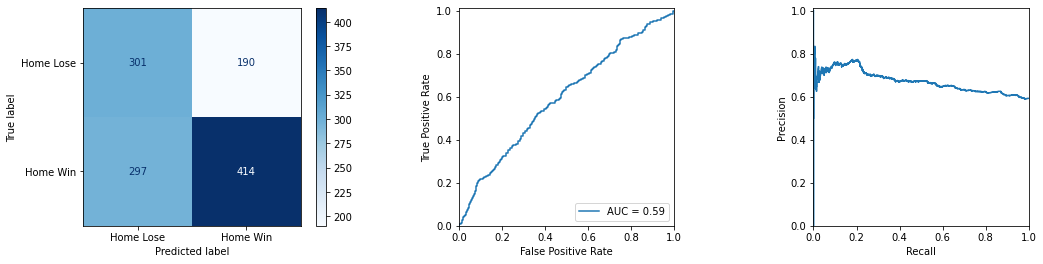

In [90]:
y_pred_2, y_true_2, *y_scores_2 = test_model(clf_2, test_features_2)
run_metrics(y_pred_2, y_true_2, y_score=y_scores_2[1])

In [91]:
accuracy_score(y_pred_2, y_true_2)

0.5948419301164726

Slight decrease in both F1 and accuracy, I think this is due to teams changing over time / going on hot or cold streaks.

## Experiment 3: 5 Game Moving Average, drop percentages

Dropping percentage columns such as field goal percentage and keeping field goals made and attempted (features used to calculate the percentage)

In [92]:
clf_3, test_features_3 = train_lr(season_avg=False, drop_percentages=True)

**Local Model Results**
------------------------------
F1 =  0.590204081632653
Best Parameters =  {'clf__C': 0.5, 'clf__penalty': 'l2'}
------------------------------


F1 = 0.6163858039198987
n games = 1202


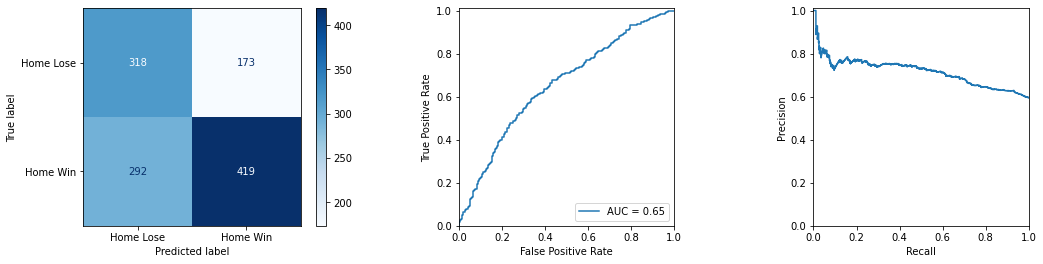

In [93]:
y_pred_3, y_true_3, *y_scores_3 = test_model(clf_3, test_features_3)
run_metrics(y_pred_3, y_true_3, y_score=y_scores_3[1])

In [94]:
accuracy_score(y_pred_3, y_true_3)

0.6131447587354409

## Experiment 4: Using Traditional Stats Only

In [95]:
clf_4, test_features_4 = train_lr(season_avg=True, drop_adv=True)

**Local Model Results**
------------------------------
F1 =  0.5869655458696554
Best Parameters =  {'clf__C': 0.5, 'clf__penalty': 'l1'}
------------------------------


F1 = 0.5916633931349584
n games = 1202


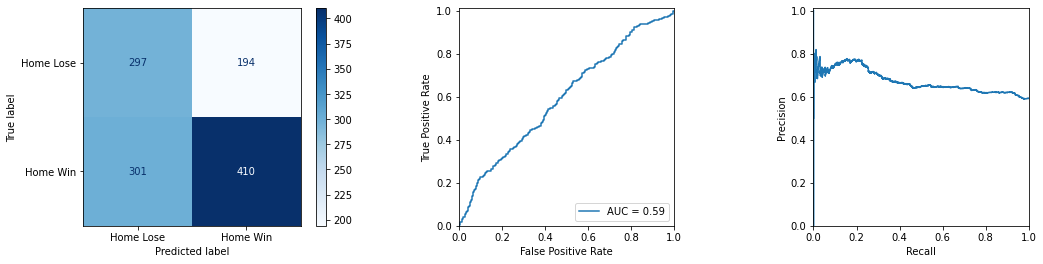

In [96]:
y_pred_4, y_true_4, *y_scores_4 = test_model(clf_4, test_features_4)
run_metrics(y_pred_4, y_true_4, y_score=y_scores_4[1])

In [98]:
accuracy_score(y_pred_4, y_true_4)

0.5881863560732113

Advanced stats look like they are valuable!!

# Random Forest

In [99]:
def train_rf(**preprocess_args):
    """Train Random Forest model with grid search cv"""
    # build dataset with given processing args
    X_train, X_test, y_train, y_test, test_full = build_dataset(**preprocess_args)
    
    # Discretize feautres
    
    rf = RandomForestClassifier(class_weight='balanced', random_state=STATE)
    params = {
        'n_estimators': [300, 500],
        'min_samples_leaf': [1, 3]
    }

    clf = GridSearchCV(rf, param_grid=params, n_jobs=-1, cv=5)
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)

    # local model results summary
    print('**Local Model Results**')
    print('-'*30)
    print('F1 = ', f1_score(y_test, y_pred))
#     print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('Best Parameters = ', clf.best_params_)
    print('-'*30)

    return clf.best_estimator_, test_full

## Experiment 1: 5 Game Moving Average

In [100]:
clf_5, test_features_5 = train_rf(season_avg=False, window=5)

**Local Model Results**
------------------------------
F1 =  0.5728395061728394
Best Parameters =  {'min_samples_leaf': 1, 'n_estimators': 500}
------------------------------


F1 = 0.6031960579856264
n games = 1202


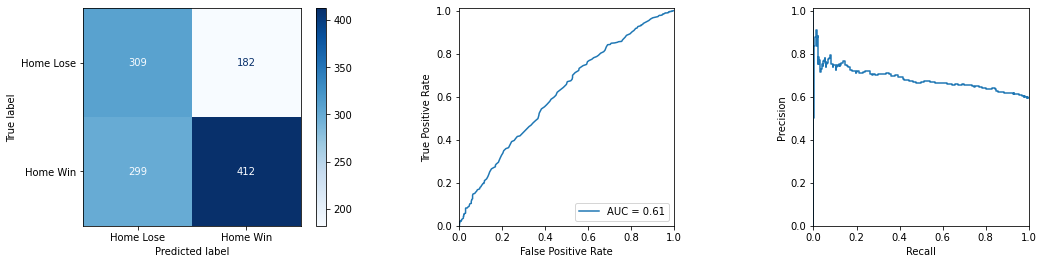

In [102]:
y_pred_5, y_true_5, *y_scores_5 = test_model(clf_5, test_features_5)
run_metrics(y_pred_5, y_true_5, y_score=y_scores_5[1])

In [104]:
accuracy_score(y_pred_5, y_true_5)

0.5998336106489185

## Experiment 2: Season Average

In [105]:
clf_6, test_features_6 = train_rf(season_avg=True)

**Local Model Results**
------------------------------
F1 =  0.5840634125990822
Best Parameters =  {'min_samples_leaf': 3, 'n_estimators': 300}
------------------------------


F1 = 0.5586477519830357
n games = 1202


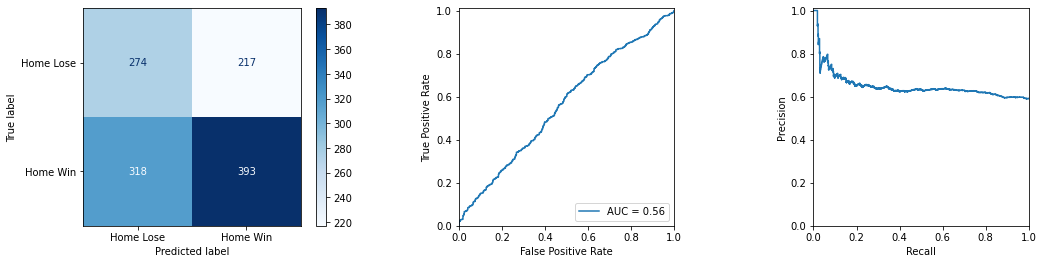

In [106]:
y_pred_6, y_true_6, *y_scores_6 = test_model(clf_6, test_features_6)
run_metrics(y_pred_6, y_true_6, y_score=y_scores_6[1])

In [107]:
accuracy_score(y_pred_6, y_true_6)

0.5549084858569051

## Experiment 3: 5 Game Moving Average, drop percentages

In [108]:
clf_7, test_features_7 = train_rf(season_avg=False, drop_percentages=True)

**Local Model Results**
------------------------------
F1 =  0.5751633986928105
Best Parameters =  {'min_samples_leaf': 3, 'n_estimators': 500}
------------------------------


F1 = 0.6064860827307349
n games = 1202


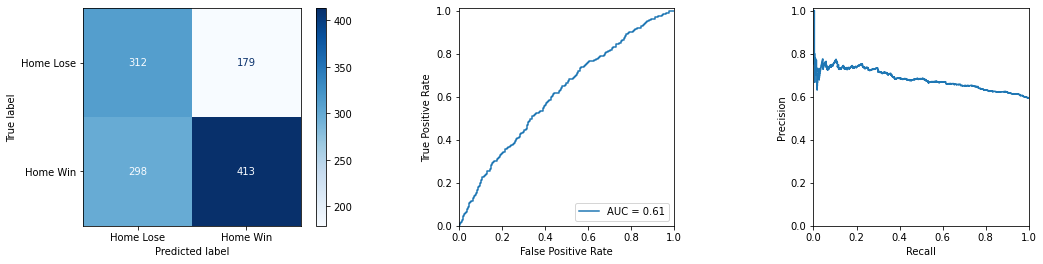

In [109]:
y_pred_7, y_true_7, *y_scores_7 = test_model(clf_7, test_features_7)
run_metrics(y_pred_7, y_true_7, y_score=y_scores_7[1])

In [111]:
accuracy_score(y_pred_7, y_true_7)

0.6031613976705491